## Pretrained GAN

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

In [3]:
import wandb
from wandb.fastai import WandbCallback
from fastai.callbacks import LearnerCallback

/home/nik/anaconda3/lib/python3.6/site-packages/wandb/fastai/__init__.py:37: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/nik/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/nik/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/nik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/nik/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/nik/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loo

In [4]:
run = wandb.init(project='superres')

In [5]:
wandb.config.batch_size = 32
wandb.config.img_size = (32,32)
#wandb.config.encoder = encoder.__name__
#wandb.config.learning_rate = 5e-3
#wandb.config.weight_decay = 1e-2
wandb.config.num_epochs = 20

## Wandb

In [6]:
superpath = '/home/nik/superres/data/' 

In [7]:
supersrc = ImageImageList.from_folder(superpath).split_by_folder(train='train', valid='test')

In [8]:
#Filter items from supersrc so that you have only the *in.jpg items
supersrc.train = supersrc.train.filter_by_func(lambda x: (x.name.find('in.jpg') != -1))

In [9]:
supersrc.valid = supersrc.valid.filter_by_func(lambda x: (x.name.find('in.jpg') != -1))

In [10]:
# Filtered version 
supersrc

ItemLists;

Train: ImageImageList (4998 items)
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: /home/nik/superres/data;

Valid: ImageImageList (669 items)
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: /home/nik/superres/data;

Test: None

In [11]:
#ef ylabels(x):
#   if str(x)
supersrc = supersrc.label_from_func(lambda x: Path(str(x).replace('in.jpg','out.jpg')))

In [12]:
supersrc

LabelLists;

Train: LabelList (4998 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/nik/superres/data;

Valid: LabelList (669 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/nik/superres/data;

Test: None

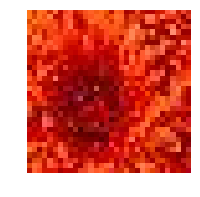

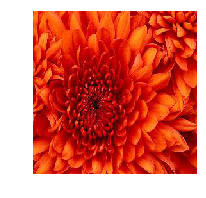

In [13]:
#LabelList with Indep and dep. variable
x,y = supersrc.train[0]
x.show()
y.show()

supersrc.train = supersrc.train.label_from_func(lambda x: Path(superpath,'train',x.name.replace('in.jpg','out.jpg')),from_item_lists=True)

supersrc.valid = supersrc.valid.label_from_func(lambda x: Path(superpath,'test',x.name.replace('in.jpg','out.jpg')),from_item_lists=True)

In [14]:
bs,size=32, 256
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

def get_superdata(bs,size):
    data = (supersrc.transform(get_transforms(max_zoom=1.), size=size, tfm_y=True)
           .databunch(bs=bs))

    data.c = 3
    return data

def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [15]:
def get_superdata(bs,size):
    data = (supersrc.databunch(bs=bs).normalize())

    data.c = 3
    return data

In [16]:
superdata_gen = get_superdata(wandb.config.batch_size ,size)
superdata_gen

ImageDataBunch;

Train: LabelList (4998 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/nik/superres/data;

Valid: LabelList (669 items)
x: ImageImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/nik/superres/data;

Test: None

In [17]:
#Grap one batch of data 
xb, yb = superdata_gen.one_batch()
xb.shape, yb.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32, 3, 256, 256]))

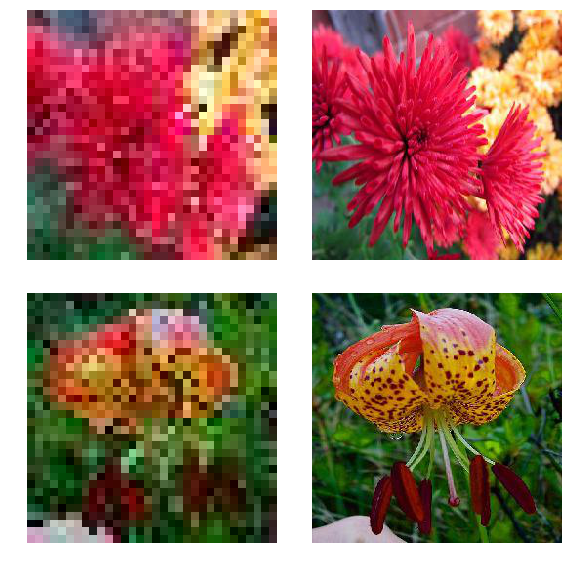

In [18]:
superdata_gen.show_batch(2)

#### Making the simple model

In [19]:
def conv(ni, nf, kernel_size=3, actn=False):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [20]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x): return x + self.m(x) * self.res_scale

In [21]:
def res_block(nf):
    return ResSequential(
        [conv(nf, nf, actn=True), conv(nf, nf)],
        0.1)

In [22]:
def upsample(ni, nf, scale):
    layers = []
    for i in range(int(math.log(scale,2))):
        layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
    return nn.Sequential(*layers)

In [23]:
class SrResnet(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        features = [conv(3, 64)]
        for i in range(8): features.append(res_block(64))
        features += [conv(64,64), upsample(64, 64, scale),
                     nn.BatchNorm2d(64),
                     conv(64, 3)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return self.features(x)

In [24]:
class SrResnet128(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        features = [conv(3, 128)]
        for i in range(8): features.append(res_block(128))
        features += [conv(128,128), upsample(128,128, scale),
                     nn.BatchNorm2d(128),
                     conv(128, 3)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return self.features(x)

In [25]:
scale = 8
torch.cuda.set_device(0)

In [26]:
# wandb loss function 
def perceptual_distance(y_true, y_pred):
    """Calculate perceptual distance, DO NOT ALTER"""
    y_true *= 255
    y_pred *= 255
    rmean = (y_true[:, :, :, 0] + y_pred[:, :, :, 0]) / 2
    r = y_true[:, :, :, 0] - y_pred[:, :, :, 0]
    g = y_true[:, :, :, 1] - y_pred[:, :, :, 1]
    b = y_true[:, :, :, 2] - y_pred[:, :, :, 2]

    return torch.mean(torch.sqrt((((512+rmean)*r*r)/256) + 4*g*g + (((767-rmean)*b*b)/256)))
metrics = [perceptual_distance]

In [29]:
###
scale = 8
m = SrResnet128(128,scale)
superlearn = Learner(superdata_gen,m,metrics=metrics,callback_fns=[WandbCallback])

In [30]:
superlearn.loss_func = F.mse_loss

In [55]:
#superlearn.loss_func = perceptual_distance

In [56]:
#superlearn.summary()

In [31]:
superlearn.fit_one_cycle(wandb.config.num_epochs, pct_start=0.8)

epoch,train_loss,valid_loss,perceptual_distance,time
0,0.068117,0.025842,112.340279,00:53
1,0.019025,0.017145,95.989311,00:52
2,0.017746,0.017978,95.111809,00:52
3,0.017134,0.017494,84.877129,00:55
4,0.018001,0.016465,78.100540,00:52
5,0.016938,0.014912,77.512505,00:55
6,0.016735,0.016255,76.145737,00:55
7,0.016781,0.015043,77.714813,00:54
8,0.016380,0.016196,75.044220,00:51
9,0.016510,0.015272,70.665741,00:51


/home/nik/fastai_v3_dev/fastai/fastai/callbacks/tracker.py:50: UserWarning: <class 'wandb.fastai.WandbCallback'> conditioned on metric `val_loss` which is not available. Available metrics are: train_loss, valid_loss, perceptual_distance
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')
/home/nik/fastai_v3_dev/fastai/fastai/callbacks/tracker.py:50: UserWarning: <class 'wandb.fastai.WandbCallback'> conditioned on metric `val_loss` which is not available. Available metrics are: train_loss, valid_loss, perceptual_distance
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')


## --------------------------------------------------------------------------------------------------------------------------